In [1]:
import copy

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import anndata as ad

In [2]:

data_dir = "/Users/apple/Desktop/QBS146_Bioinfo_I/final_project/dataset"
adata = ad.read_h5ad(data_dir+'/h5ad/2024_xenium_breast_tTMA1.h5ad')


# 

In [3]:
adata.shape

(342704, 541)

In [5]:
adata.obs.columns

Index(['x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts',
       'control_codeword_counts', 'unassigned_codeword_counts',
       'deprecated_codeword_counts', 'total_counts', 'cell_area',
       'nucleus_area', 'x', 'y', 'core', 'tissue_type'],
      dtype='object')

In [11]:
print("n_cells:", adata.n_obs)
print("n_genes:", adata.n_vars)
print("n_cores:", adata.obs["core"].nunique())
print(adata.obs["tissue_type"].value_counts())

n_cells: 342704
n_genes: 541
n_cores: 145
tissue_type
OvC           51209
Tonsil        48990
CRC           45526
NSCLC         42979
BlC           39690
HNSCC         36232
BrC           23758
Melanoma      22520
Lymph node    21778
MARKER        10022
Name: count, dtype: int64


In [9]:
adata.obsm.keys

<bound method Mapping.keys of AxisArrays with keys: spatial>

In [ ]:
adata.obsm.keys

<bound method Mapping.keys of AxisArrays with keys: spatial>

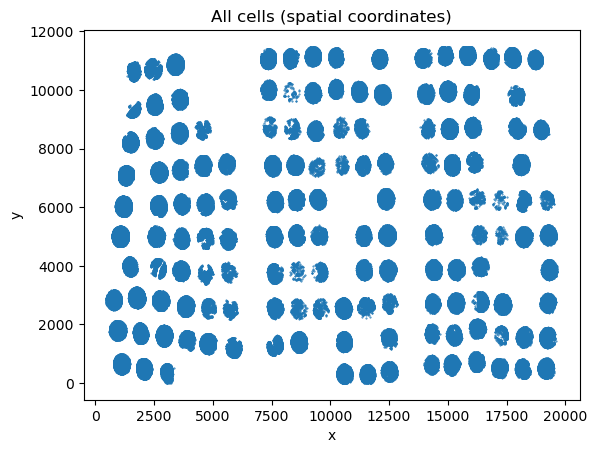

In [12]:
import matplotlib.pyplot as plt

xy = adata.obsm["spatial"]
plt.figure()
plt.scatter(xy[:,0], xy[:,1], s=0.2)
plt.xlabel("x"); plt.ylabel("y")
plt.title("All cells (spatial coordinates)")
plt.show()

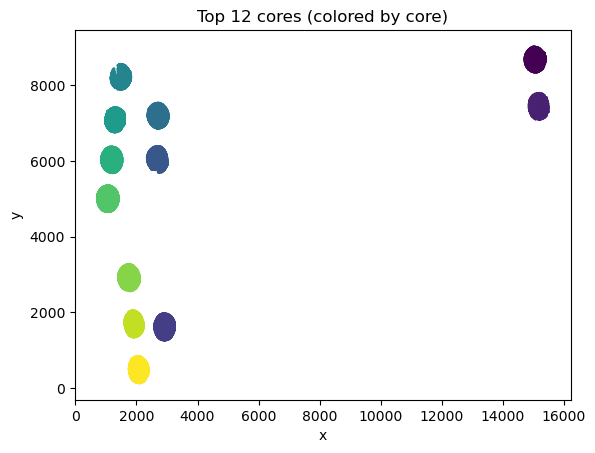

In [13]:
core_counts = adata.obs["core"].value_counts()
top_cores = core_counts.head(12).index

sub = adata[adata.obs["core"].isin(top_cores)].copy()
xy = sub.obsm["spatial"]

plt.figure()
plt.scatter(xy[:,0], xy[:,1], s=1, c=pd.Categorical(sub.obs["core"]).codes)
plt.xlabel("x"); plt.ylabel("y")
plt.title("Top 12 cores (colored by core)")
plt.show()

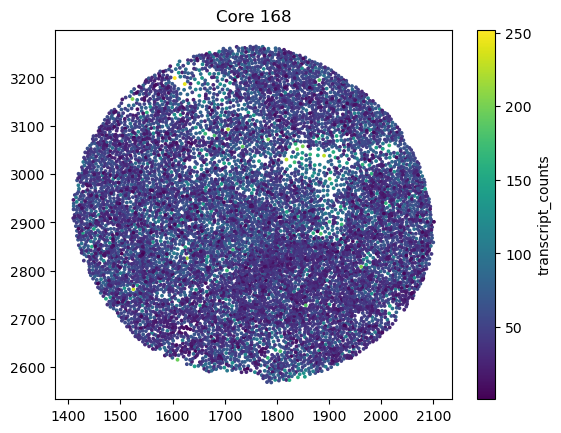

In [19]:
import matplotlib.pyplot as plt

core_id = adata.obs["core"].value_counts().index[0]
ad = adata[adata.obs["core"] == core_id]

xy = ad.obsm["spatial"]

plt.figure()
plt.scatter(xy[:,0], xy[:,1], s=3, c=ad.obs["transcript_counts"])
plt.colorbar(label="transcript_counts")
plt.title(f"Core {core_id}")
plt.show()

/opt/anaconda3/envs/LCL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


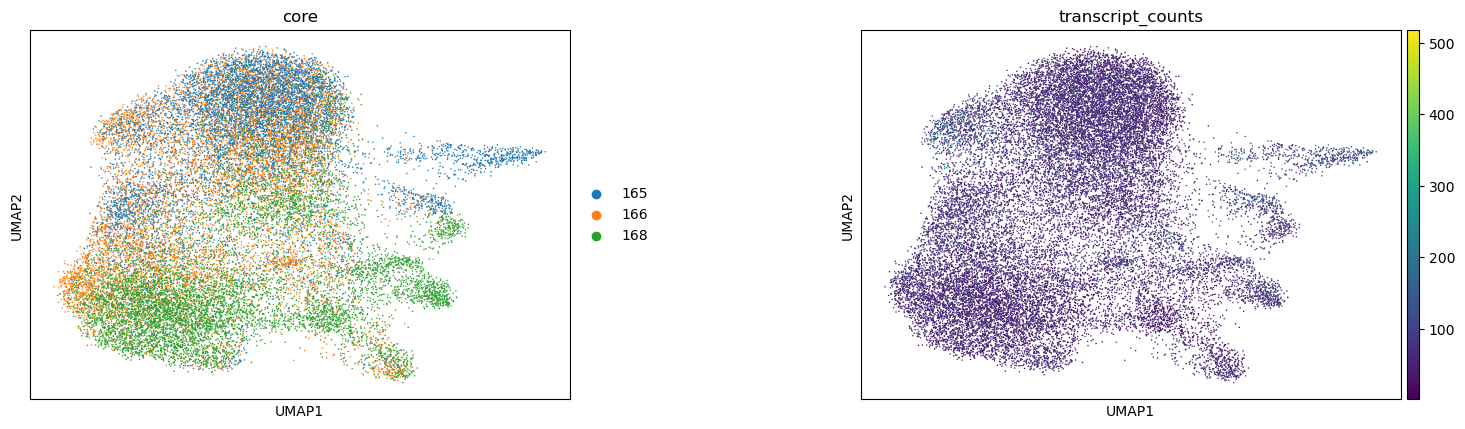

In [14]:
import scanpy as sc

ad_small = adata[adata.obs["core"].isin(adata.obs["core"].value_counts().head(3).index)].copy()
sc.pp.normalize_total(ad_small)
sc.pp.log1p(ad_small)
sc.pp.highly_variable_genes(ad_small, n_top_genes=2000)
ad_small = ad_small[:, ad_small.var["highly_variable"]].copy()
sc.pp.pca(ad_small)
sc.pp.neighbors(ad_small)
sc.tl.umap(ad_small)

sc.pl.umap(ad_small, color=["core", "transcript_counts"], wspace=0.4)